In [1]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random
import tensorflow as tf
import keras_tuner as kt

SEED = 42  
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-05-05 23:19:47.230974: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Loading and Reading the dataset
df = pd.read_csv('/Users/ramyavissapragada/Desktop/Applied Deep Learning/Project/loan_data.csv')
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [3]:
# Summary statistics for numerical features
print(df.describe())

         person_age  person_income  person_emp_exp     loan_amnt  \
count  45000.000000   4.500000e+04    45000.000000  45000.000000   
mean      27.764178   8.031905e+04        5.410333   9583.157556   
std        6.045108   8.042250e+04        6.063532   6314.886691   
min       20.000000   8.000000e+03        0.000000    500.000000   
25%       24.000000   4.720400e+04        1.000000   5000.000000   
50%       26.000000   6.704800e+04        4.000000   8000.000000   
75%       30.000000   9.578925e+04        8.000000  12237.250000   
max      144.000000   7.200766e+06      125.000000  35000.000000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
count   45000.000000         45000.000000                45000.000000   
mean       11.006606             0.139725                    5.867489   
std         2.978808             0.087212                    3.879702   
min         5.420000             0.000000                    2.000000   
25%         8.590000  

In [4]:
# Information on data types and missing values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [5]:
# Count missing values in each column
print(df.isnull().sum())


person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64


In [6]:
# Printing the value counts for each categorical column
for column in df.select_dtypes(include=['object']).columns:
    print(f"\nColumn: {column}")
    print(df[column].value_counts())



Column: person_gender
person_gender
male      24841
female    20159
Name: count, dtype: int64

Column: person_education
person_education
Bachelor       13399
Associate      12028
High School    11972
Master          6980
Doctorate        621
Name: count, dtype: int64

Column: person_home_ownership
person_home_ownership
RENT        23443
MORTGAGE    18489
OWN          2951
OTHER         117
Name: count, dtype: int64

Column: loan_intent
loan_intent
EDUCATION            9153
MEDICAL              8548
VENTURE              7819
PERSONAL             7552
DEBTCONSOLIDATION    7145
HOMEIMPROVEMENT      4783
Name: count, dtype: int64

Column: previous_loan_defaults_on_file
previous_loan_defaults_on_file
Yes    22858
No     22142
Name: count, dtype: int64


In [7]:
# Looking at the outcome variable - class distribution
df['loan_status'].value_counts()

loan_status
0    35000
1    10000
Name: count, dtype: int64

In [8]:
# Capping the age at 100
df['person_age'] = df['person_age'].apply(lambda x: min(x, 100))


In [9]:
# Capping income at the 99th percentile
income_cap = df['person_income'].quantile(0.99)
df['person_income'] = df['person_income'].apply(lambda x: min(x, income_cap))


In [10]:
# Transforming the experience duration column
baseline_age = 14  # Setting the minimum plausible working age

# Deriving the maximum plausible experience for each individual
df['adjusted_emp_exp'] = df.apply(
    lambda row: min(row['person_emp_exp'], row['person_age'] - baseline_age), axis=1
)


In [11]:
# Quick-Check
print(df.describe())

         person_age  person_income  person_emp_exp     loan_amnt  \
count  45000.000000   45000.000000    45000.000000  45000.000000   
mean      27.759667   78045.597333        5.410333   9583.157556   
std        5.977583   45467.702511        6.063532   6314.886691   
min       20.000000    8000.000000        0.000000    500.000000   
25%       24.000000   47204.000000        1.000000   5000.000000   
50%       26.000000   67048.000000        4.000000   8000.000000   
75%       30.000000   95789.250000        8.000000  12237.250000   
max      100.000000  271450.060000      125.000000  35000.000000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
count   45000.000000         45000.000000                45000.000000   
mean       11.006606             0.139725                    5.867489   
std         2.978808             0.087212                    3.879702   
min         5.420000             0.000000                    2.000000   
25%         8.590000  

In [12]:
# Looking at the columns
df.columns

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'previous_loan_defaults_on_file', 'loan_status',
       'adjusted_emp_exp'],
      dtype='object')

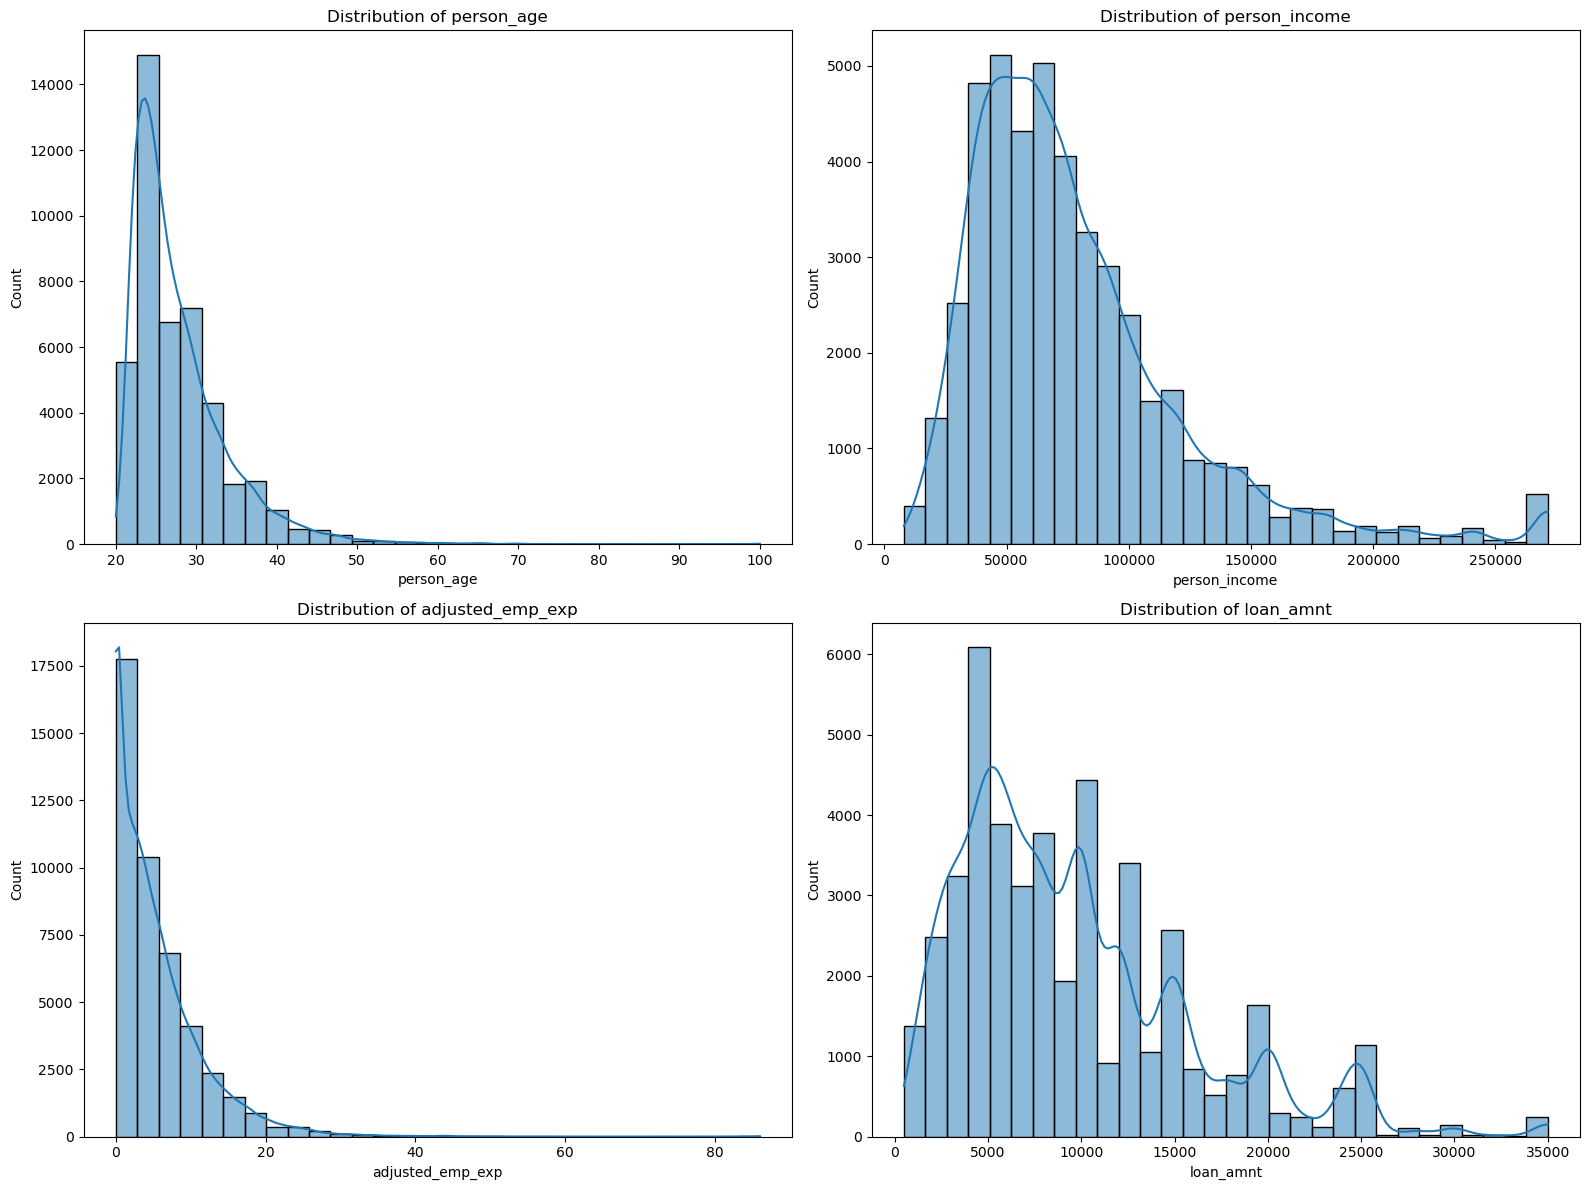

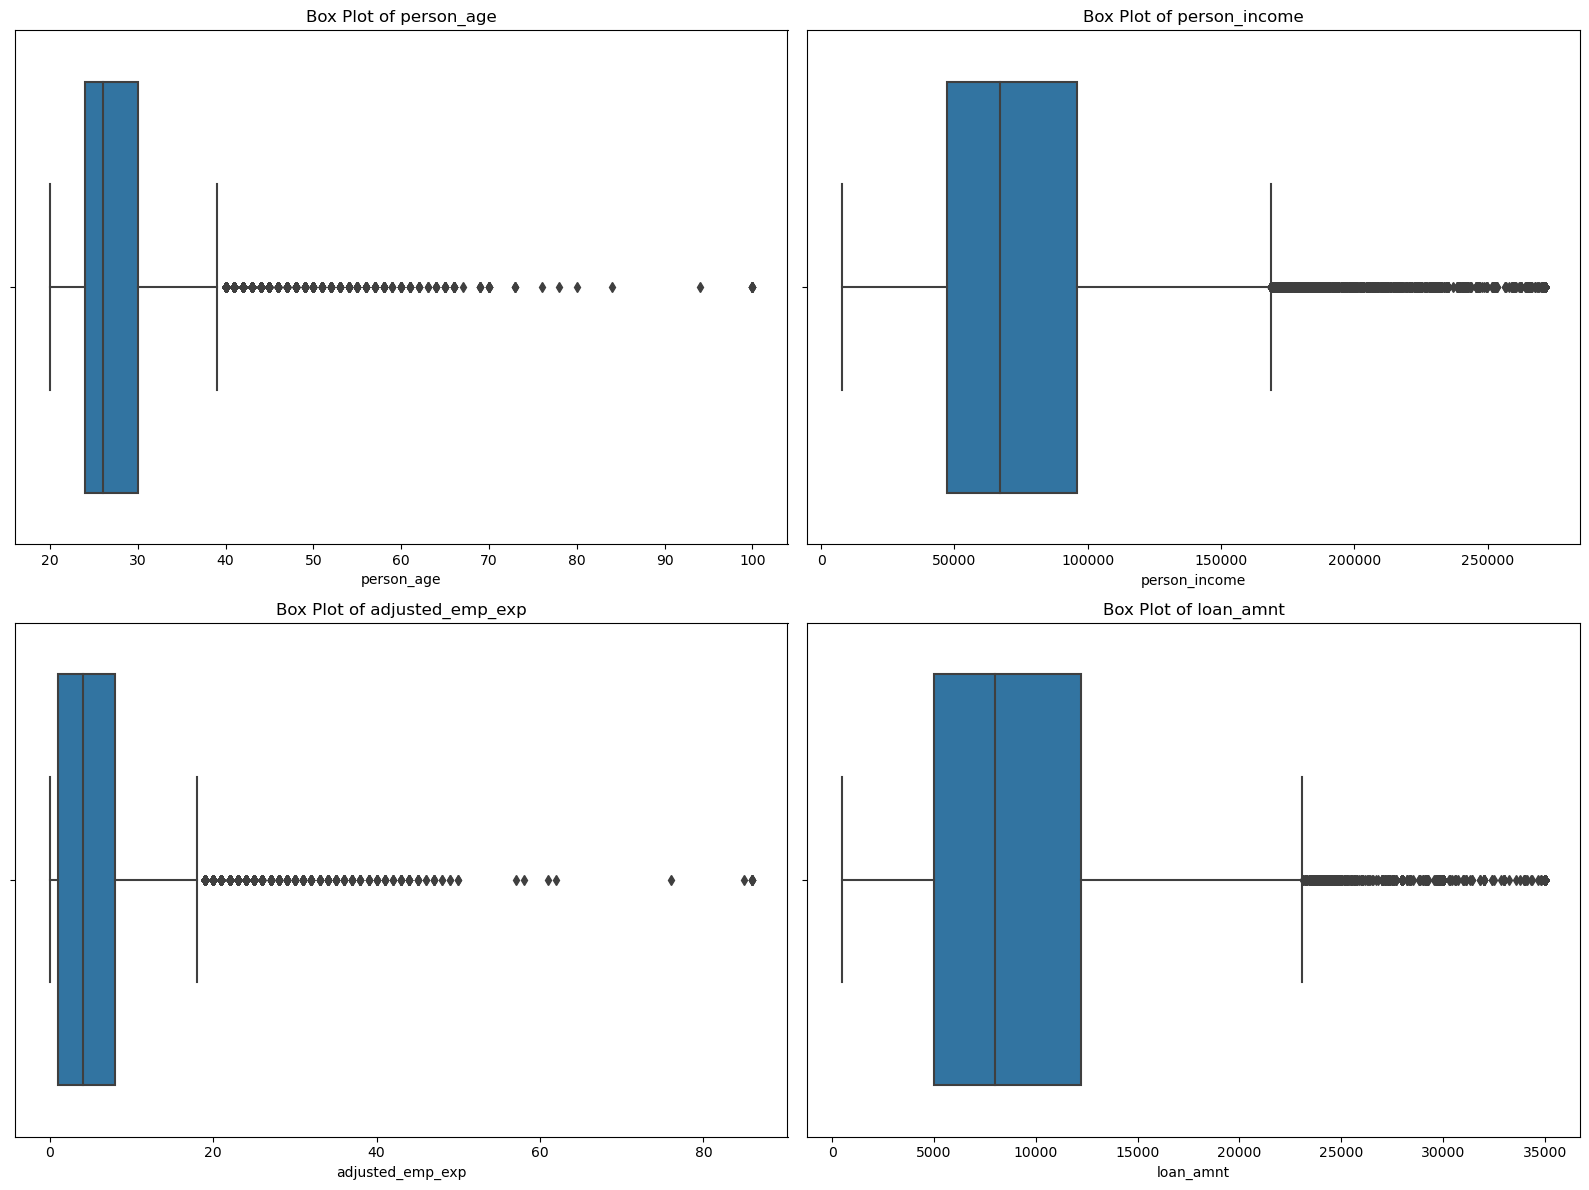

In [13]:
# Looking at skewness and outliers
import matplotlib.pyplot as plt
import seaborn as sns

# Variables to visualize
vars_to_plot = ['person_age', 'person_income', 'adjusted_emp_exp', 'loan_amnt']

plt.figure(figsize=(16, 12))

# Histograms
for i, col in enumerate(vars_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

# Box Plots
plt.figure(figsize=(16, 12))
for i, col in enumerate(vars_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')

plt.tight_layout()
plt.show()


In [14]:
# Qucik-Check
violations = df[df['adjusted_emp_exp'] > (df['person_age'] - 14)]
print(f"Number of violations: {len(violations)}")


Number of violations: 0


In [15]:
# Using log-transformation

df['person_income_log'] = np.log1p(df['person_income'])  # +1 to avoid log(0)
df['adjusted_emp_exp_log'] = np.log1p(df['adjusted_emp_exp'])
df['loan_amnt_log'] = np.log1p(df['loan_amnt'])

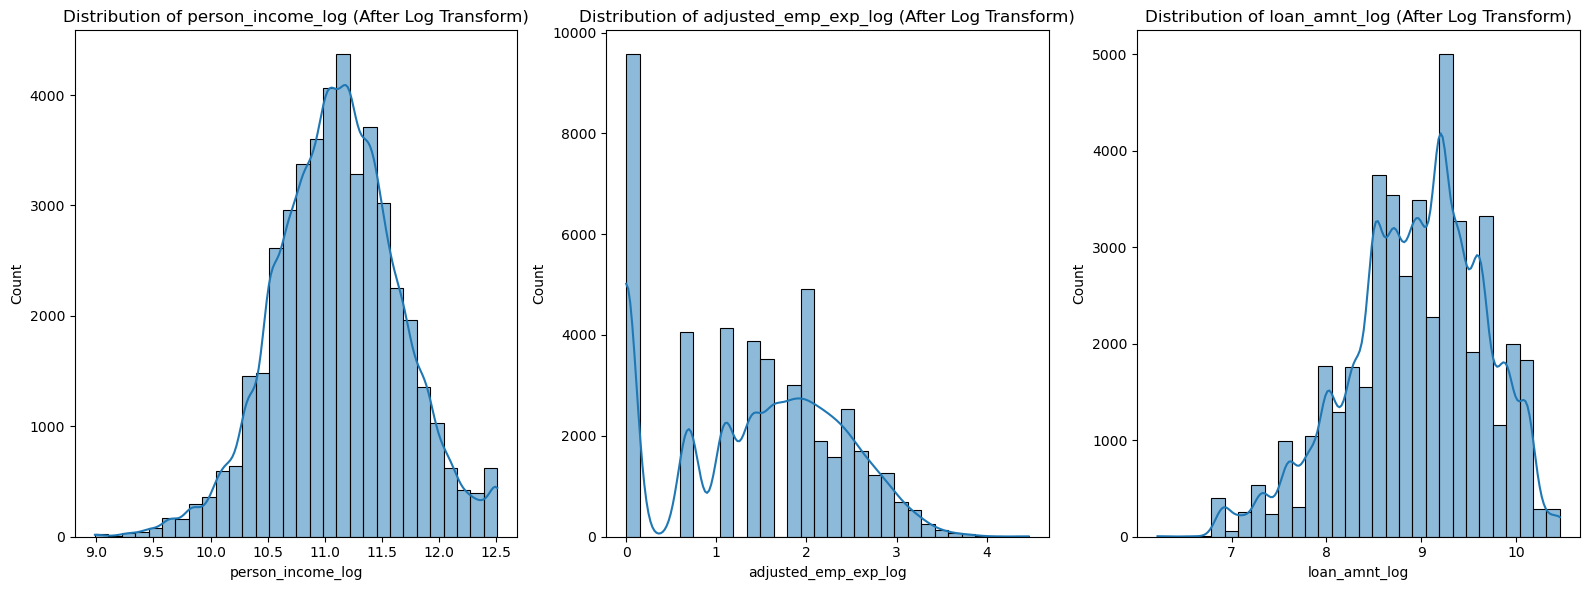

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# After transformation columns
after_transform_cols = ['person_income_log', 'adjusted_emp_exp_log', 'loan_amnt_log']

plt.figure(figsize=(16, 6))

# Histograms after log transform
for i, col in enumerate(after_transform_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col} (After Log Transform)')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


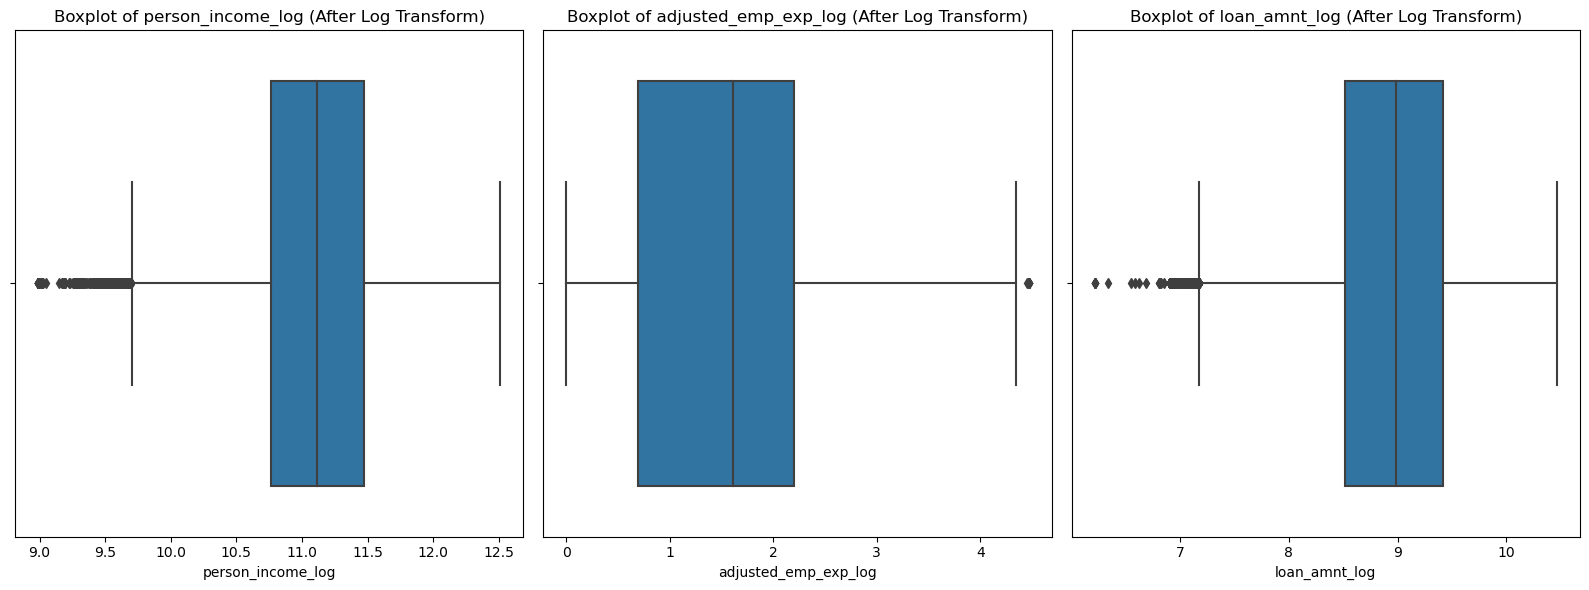

In [17]:
plt.figure(figsize=(16, 6))

for i, col in enumerate(after_transform_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col} (After Log Transform)')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


In [18]:
# One Hot Encoding
df = pd.get_dummies(df, columns=[
    'person_gender', 'person_education', 'person_home_ownership', 
    'loan_intent', 'previous_loan_defaults_on_file'
], drop_first=True)


In [19]:
df.columns

Index(['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'loan_status', 'adjusted_emp_exp', 'person_income_log',
       'adjusted_emp_exp_log', 'loan_amnt_log', 'person_gender_male',
       'person_education_Bachelor', 'person_education_Doctorate',
       'person_education_High School', 'person_education_Master',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'previous_loan_defaults_on_file_Yes'],
      dtype='object')

In [20]:
# Quick Check
print(df.describe())

         person_age  person_income  person_emp_exp     loan_amnt  \
count  45000.000000   45000.000000    45000.000000  45000.000000   
mean      27.759667   78045.597333        5.410333   9583.157556   
std        5.977583   45467.702511        6.063532   6314.886691   
min       20.000000    8000.000000        0.000000    500.000000   
25%       24.000000   47204.000000        1.000000   5000.000000   
50%       26.000000   67048.000000        4.000000   8000.000000   
75%       30.000000   95789.250000        8.000000  12237.250000   
max      100.000000  271450.060000      125.000000  35000.000000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
count   45000.000000         45000.000000                45000.000000   
mean       11.006606             0.139725                    5.867489   
std         2.978808             0.087212                    3.879702   
min         5.420000             0.000000                    2.000000   
25%         8.590000  

In [21]:
# Target variable
y = df['loan_status']

# Features — dropping raw and target columns
X = df.drop([
    'loan_status',
    'person_income',         
    'person_emp_exp',        
    'loan_amnt',            
    'adjusted_emp_exp'    
], axis=1)


In [22]:
# Splitting the dataset
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42
)


In [23]:
# Scaling the numerical data
from sklearn.preprocessing import StandardScaler

numeric_cols = [
    'person_age', 'person_income_log', 'adjusted_emp_exp_log',
    'loan_amnt_log', 'loan_int_rate', 'loan_percent_income',
    'cb_person_cred_hist_length', 'credit_score'
]

scaler = StandardScaler()

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [24]:
# Looking at the class weights - Quick check
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: 0.6428571428571429, 1: 2.25}


In [25]:
# Small Baseline Model

from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
from sklearn.metrics import f1_score

def build_small_model(input_dim):
    model = tf.keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

small_model = build_small_model(X_train.shape[1])
history_small = small_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# Evaluating
val_loss, val_acc, val_auc = small_model.evaluate(X_val, y_val)
test_loss, test_acc, test_auc = small_model.evaluate(X_test, y_test)

y_pred_small = (small_model.predict(X_test) > 0.5).astype("int32")
f1_small = f1_score(y_test, y_pred_small)

print(f"Val Accuracy: {val_acc:.4f}, Val AUC: {val_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")
print(f"F1 Score: {f1_small:.4f}")


Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6702 - auc: 0.8363 - loss: 0.5115 - val_accuracy: 0.8763 - val_auc: 0.9459 - val_loss: 0.2891
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8764 - auc: 0.9530 - loss: 0.2813 - val_accuracy: 0.8774 - val_auc: 0.9560 - val_loss: 0.2520
Epoch 3/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8751 - auc: 0.9592 - loss: 0.2511 - val_accuracy: 0.8783 - val_auc: 0.9575 - val_loss: 0.2443
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8755 - auc: 0.9611 - loss: 0.2431 - val_accuracy: 0.8804 - val_auc: 0.9584 - val_loss: 0.2404
Epoch 5/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8755 - auc: 0.9623 - loss: 0.2391 - val_accuracy: 0.8810 - val_auc: 0.9591 - val_loss: 0.2376
Epoch 6/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8754 - auc: 0.9631 - loss: 0.2365 - val_accuracy: 0.8822 - val_auc: 0.9597 - val_loss: 0.2356
Epoch 7/100
422/422 ━━━━━━━━━━━━━━

In [26]:
# Deep - Baseline Neural Network: 

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import f1_score

# Define model
def build_baseline_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

# Instantiating the model
model = build_baseline_model(X_train.shape[1])

# Early stopping
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Training the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1
)

# Evaluating
val_loss, val_acc, val_auc = model.evaluate(X_val, y_val)
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test)

# Prediction & F1-Score
y_pred = (model.predict(X_test) > 0.5).astype("int32")
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)

print(f"Val Accuracy: {val_acc:.4f}, Val AUC: {val_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")
print(f"F1 Score: {f1:.4f}")



Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8225 - auc: 0.9113 - loss: 0.3647 - val_accuracy: 0.8924 - val_auc: 0.9588 - val_loss: 0.2281
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8745 - auc: 0.9624 - loss: 0.2383 - val_accuracy: 0.8939 - val_auc: 0.9610 - val_loss: 0.2236
Epoch 3/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8773 - auc: 0.9647 - loss: 0.2311 - val_accuracy: 0.8942 - val_auc: 0.9622 - val_loss: 0.2196
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8803 - auc: 0.9663 - loss: 0.2258 - val_accuracy: 0.8946 - val_auc: 0.9629 - val_loss: 0.2161
Epoch 5/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8827 - auc: 0.9675 - loss: 0.2217 - val_accuracy: 0.8953 - val_auc: 0.9635 - val_loss: 0.2142
Epoch 6/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8846 - auc: 0.9684 - loss: 0.2183 - val_accuracy: 0.8961 - val_auc: 0.9637 - val_loss: 0.2128
Epoch 7/100
422/422 ━━━━━━━━━━━━━━

In [27]:
# Dropout model architecture
def build_dropout_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

# Instantiating and training
model_dropout = build_dropout_model(X_train.shape[1])
history_dropout = model_dropout.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# Evaluating
val_loss, val_acc, val_auc = model_dropout.evaluate(X_val, y_val)
test_loss, test_acc, test_auc = model_dropout.evaluate(X_test, y_test)

# Prediction & F1-Score
y_pred_dropout = (model_dropout.predict(X_test) > 0.5).astype("int32")
f1_dropout = f1_score(y_test, y_pred_dropout)

print(f"Val Accuracy: {val_acc:.4f}, Val AUC: {val_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")
print(f"F1 Score: {f1_dropout:.4f}")


Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8104 - auc: 0.8897 - loss: 0.4007 - val_accuracy: 0.8812 - val_auc: 0.9590 - val_loss: 0.2413
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8702 - auc: 0.9572 - loss: 0.2542 - val_accuracy: 0.8833 - val_auc: 0.9605 - val_loss: 0.2388
Epoch 3/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8732 - auc: 0.9604 - loss: 0.2443 - val_accuracy: 0.8850 - val_auc: 0.9621 - val_loss: 0.2330
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8746 - auc: 0.9612 - loss: 0.2400 - val_accuracy: 0.8858 - val_auc: 0.9630 - val_loss: 0.2283
Epoch 5/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8765 - auc: 0.9628 - loss: 0.2371 - val_accuracy: 0.8871 - val_auc: 0.9637 - val_loss: 0.2282
Epoch 6/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8797 - auc: 0.9639 - loss: 0.2327 - val_accuracy: 0.8876 - val_auc: 0.9643 - val_loss: 0.2260
Epoch 7/100
422/422 ━━━━━━━━━━━━━━

In [28]:
# BatchNorm model architecture
def build_batchnorm_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        
        layers.Dense(64),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

# Instantiating and training
model_bn = build_batchnorm_model(X_train.shape[1])
history_bn = model_bn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# Evaluating
val_loss, val_acc, val_auc = model_bn.evaluate(X_val, y_val)
test_loss, test_acc, test_auc = model_bn.evaluate(X_test, y_test)

# Prediction & F1-Score
y_pred_bn = (model_bn.predict(X_test) > 0.5).astype("int32")
f1_bn = f1_score(y_test, y_pred_bn)

print(f"Val Accuracy: {val_acc:.4f}, Val AUC: {val_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")
print(f"F1 Score: {f1_bn:.4f}")


Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8178 - auc: 0.9307 - loss: 0.3312 - val_accuracy: 0.8791 - val_auc: 0.9595 - val_loss: 0.2544
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8794 - auc: 0.9626 - loss: 0.2398 - val_accuracy: 0.8820 - val_auc: 0.9608 - val_loss: 0.2407
Epoch 3/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8833 - auc: 0.9655 - loss: 0.2294 - val_accuracy: 0.8878 - val_auc: 0.9619 - val_loss: 0.2329
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8863 - auc: 0.9675 - loss: 0.2223 - val_accuracy: 0.8904 - val_auc: 0.9620 - val_loss: 0.2286
Epoch 5/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8876 - auc: 0.9691 - loss: 0.2167 - val_accuracy: 0.8894 - val_auc: 0.9621 - val_loss: 0.2279
Epoch 6/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8901 - auc: 0.9704 - loss: 0.2118 - val_accuracy: 0.8888 - val_auc: 0.9617 - val_loss: 0.2268
Epoch 7/100
422/422 ━━━━━━━━━━━━━━

In [29]:
# Leaky-ReLU architecture
from tensorflow.keras.layers import LeakyReLU

def build_leakyrelu_dropout_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128),
        LeakyReLU(negative_slope=0.01),
        layers.Dropout(0.3),
        
        layers.Dense(64),
        LeakyReLU(negative_slope=0.01),
        layers.Dropout(0.2),
        
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

# Training the model
model_leaky = build_leakyrelu_dropout_model(X_train.shape[1])
history_leaky = model_leaky.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# Evaluating
val_loss, val_acc, val_auc = model_leaky.evaluate(X_val, y_val)
test_loss, test_acc, test_auc = model_leaky.evaluate(X_test, y_test)

# Prediction & F1-Score
y_pred_leaky = (model_leaky.predict(X_test) > 0.5).astype("int32")
f1_leaky = f1_score(y_test, y_pred_leaky)

print(f"Val Accuracy: {val_acc:.4f}, Val AUC: {val_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")
print(f"F1 Score: {f1_leaky:.4f}")


Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8028 - auc: 0.8895 - loss: 0.4001 - val_accuracy: 0.8830 - val_auc: 0.9584 - val_loss: 0.2413
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8662 - auc: 0.9562 - loss: 0.2562 - val_accuracy: 0.8818 - val_auc: 0.9602 - val_loss: 0.2435
Epoch 3/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8715 - auc: 0.9593 - loss: 0.2464 - val_accuracy: 0.8869 - val_auc: 0.9613 - val_loss: 0.2328
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8769 - auc: 0.9617 - loss: 0.2394 - val_accuracy: 0.8870 - val_auc: 0.9623 - val_loss: 0.2304
Epoch 5/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8780 - auc: 0.9631 - loss: 0.2354 - val_accuracy: 0.8859 - val_auc: 0.9633 - val_loss: 0.2334
Epoch 6/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8803 - auc: 0.9641 - loss: 0.2325 - val_accuracy: 0.8891 - val_auc: 0.9641 - val_loss: 0.2270
Epoch 7/100
422/422 ━━━━━━━━━━━━━━

In [30]:
# RMSprop + Dropout model
def build_rmsprop_dropout_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

# Training the model
model_rms = build_rmsprop_dropout_model(X_train.shape[1])
history_rms = model_rms.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# Evaluating
val_loss, val_acc, val_auc = model_rms.evaluate(X_val, y_val)
test_loss, test_acc, test_auc = model_rms.evaluate(X_test, y_test)

# Prediction & F1-Score
y_pred_rms = (model_rms.predict(X_test) > 0.5).astype("int32")
f1_rms = f1_score(y_test, y_pred_rms)

print(f"Val Accuracy: {val_acc:.4f}, Val AUC: {val_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")
print(f"F1 Score: {f1_rms:.4f}")


Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7939 - auc: 0.9027 - loss: 0.3931 - val_accuracy: 0.8770 - val_auc: 0.9580 - val_loss: 0.2538
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8728 - auc: 0.9580 - loss: 0.2505 - val_accuracy: 0.8819 - val_auc: 0.9595 - val_loss: 0.2423
Epoch 3/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8734 - auc: 0.9596 - loss: 0.2461 - val_accuracy: 0.8804 - val_auc: 0.9601 - val_loss: 0.2466
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8775 - auc: 0.9619 - loss: 0.2400 - val_accuracy: 0.8830 - val_auc: 0.9615 - val_loss: 0.2372
Epoch 5/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8778 - auc: 0.9629 - loss: 0.2361 - val_accuracy: 0.8826 - val_auc: 0.9623 - val_loss: 0.2355
Epoch 6/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8784 - auc: 0.9633 - loss: 0.2361 - val_accuracy: 0.8846 - val_auc: 0.9625 - val_loss: 0.2315
Epoch 7/100
422/422 ━━━━━━━━━━━━━━

In [31]:
# SGD Optimizer Model

from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
from sklearn.metrics import f1_score

def build_sgd_model(input_dim):
    model = tf.keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

sgd_model = build_sgd_model(X_train.shape[1])
history_sgd = sgd_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# Evaluating
val_loss, val_acc, val_auc = sgd_model.evaluate(X_val, y_val)
test_loss, test_acc, test_auc = sgd_model.evaluate(X_test, y_test)

y_pred_sgd = (sgd_model.predict(X_test) > 0.5).astype("int32")
f1_sgd = f1_score(y_test, y_pred_sgd)

print(f"Val Accuracy: {val_acc:.4f}, Val AUC: {val_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")
print(f"F1 Score: {f1_sgd:.4f}")


Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7720 - auc: 0.8656 - loss: 0.4362 - val_accuracy: 0.8833 - val_auc: 0.9577 - val_loss: 0.2424
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8660 - auc: 0.9538 - loss: 0.2647 - val_accuracy: 0.8851 - val_auc: 0.9598 - val_loss: 0.2325
Epoch 3/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8700 - auc: 0.9577 - loss: 0.2525 - val_accuracy: 0.8827 - val_auc: 0.9609 - val_loss: 0.2395
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8713 - auc: 0.9596 - loss: 0.2472 - val_accuracy: 0.8864 - val_auc: 0.9616 - val_loss: 0.2333
Epoch 5/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8774 - auc: 0.9615 - loss: 0.2402 - val_accuracy: 0.8846 - val_auc: 0.9620 - val_loss: 0.2334
Epoch 6/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8760 - auc: 0.9623 - loss: 0.2381 - val_accuracy: 0.8857 - val_auc: 0.9629 - val_loss: 0.2285
Epoch 7/100
422/422 ━━━━━━━━━━━━━━

In [32]:
# Keras Tuner - Hyperband Optimized Model

def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))

    # First hidden layer
    units_1 = hp.Int('units_1', min_value=64, max_value=256, step=32)
    act_1 = hp.Choice('act_1', values=['relu', 'leaky_relu'])
    dropout_1 = hp.Float('dropout_1', 0.2, 0.5, step=0.1)

    model.add(tf.keras.layers.Dense(units_1))
    if act_1 == 'leaky_relu':
        model.add(tf.keras.layers.LeakyReLU(negative_slope=0.01))
    else:
        model.add(tf.keras.layers.Activation(act_1))
    model.add(tf.keras.layers.Dropout(dropout_1))

    # Second hidden layer
    if hp.Boolean("add_second_layer"):
        units_2 = hp.Int('units_2', 32, 128, step=32)
        act_2 = hp.Choice('act_2', values=['relu', 'leaky_relu'])
        dropout_2 = hp.Float('dropout_2', 0.2, 0.5, step=0.1)

        model.add(tf.keras.layers.Dense(units_2))
        if act_2 == 'leaky_relu':
            model.add(tf.keras.layers.LeakyReLU(negative_slope=0.01))
        else:
            model.add(tf.keras.layers.Activation(act_2))
        model.add(tf.keras.layers.Dropout(dropout_2))

    # Output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compiling
    lr = hp.Float("lr", 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model


In [33]:
# Keras Tuner - Hyperband Search
tuner = kt.Hyperband(
    build_model,
    objective='val_auc',
    max_epochs=30,
    factor=3,
    directory='kt_logs',
    project_name='loan_model_tuning',
    overwrite=True,
    seed = 42
)

In [34]:
# Running Hyperband Tuning Search 
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=50,
             batch_size=64,
             class_weight=class_weights,
             callbacks=[stop_early])

Trial 90 Complete [00h 00m 18s]
val_auc: 0.9648364782333374

Best val_auc So Far: 0.9663034677505493
Total elapsed time: 00h 11m 42s


In [35]:
# Evaluating the Best Tuned Model
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters(1)[0]

# Prediction and F1-Score
val_loss, val_acc, val_auc = best_model.evaluate(X_val, y_val)
test_loss, test_acc, test_auc = best_model.evaluate(X_test, y_test)
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")
f1_best = f1_score(y_test, y_pred)

print("Best Hyperparameters:", best_hyperparams.values)
print(f"Val Accuracy: {val_acc:.4f}, Val AUC: {val_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")
print(f"F1 Score: {f1_best:.4f}")


/Users/ramyavissapragada/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8873 - auc: 0.9665 - loss: 0.2143
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8870 - auc: 0.9700 - loss: 0.2089
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
Best Hyperparameters: {'units_1': 160, 'act_1': 'relu', 'dropout_1': 0.4, 'add_second_layer': True, 'lr': 0.0015141913494764387, 'units_2': 96, 'act_2': 'relu', 'dropout_2': 0.4, 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0069'}
Val Accuracy: 0.8849, Val AUC: 0.9663
Test Accuracy: 0.8877, Test AUC: 0.9691
F1 Score: 0.7823


Epoch 1/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8123 - auc: 0.9055 - loss: 0.3728 - val_accuracy: 0.8824 - val_auc: 0.9591 - val_loss: 0.2372
Epoch 2/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8697 - auc: 0.9578 - loss: 0.2504 - val_accuracy: 0.8816 - val_auc: 0.9611 - val_loss: 0.2332
Epoch 3/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8721 - auc: 0.9607 - loss: 0.2430 - val_accuracy: 0.8840 - val_auc: 0.9621 - val_loss: 0.2284
Epoch 4/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8766 - auc: 0.9623 - loss: 0.2385 - val_accuracy: 0.8857 - val_auc: 0.9635 - val_loss: 0.2282
Epoch 5/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8776 - auc: 0.9635 - loss: 0.2349 - val_accuracy: 0.8867 - val_auc: 0.9644 - val_loss: 0.2232
Epoch 6/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8770 - auc: 0.9646 - loss: 0.2301 - val_accuracy: 0.8891 - val_auc: 0.9648 - val_loss: 0.2189
Epoch 7/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 

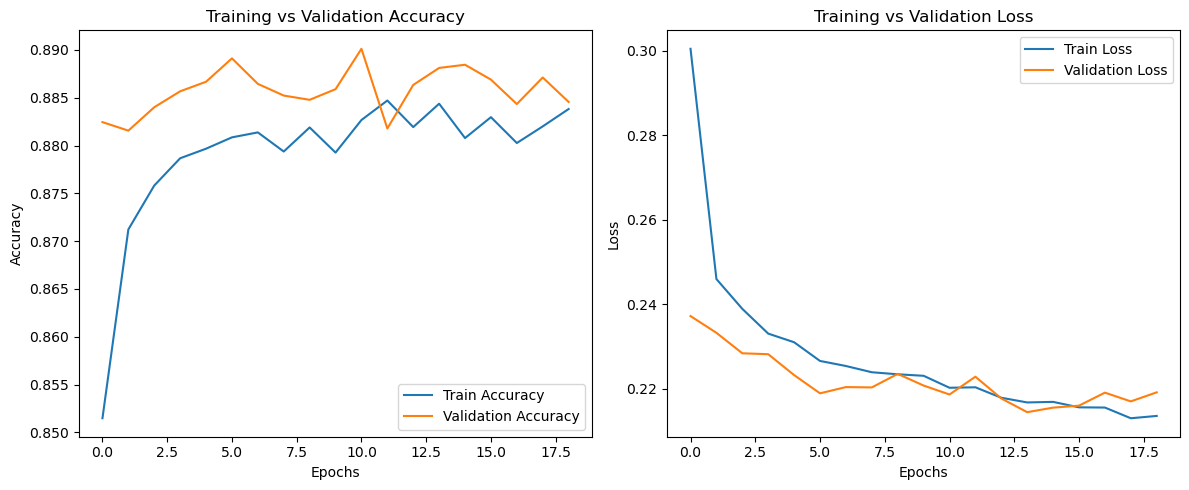

In [36]:
# Build model again using best hyperparameters
model = build_model(best_hyperparams)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# Now plot
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


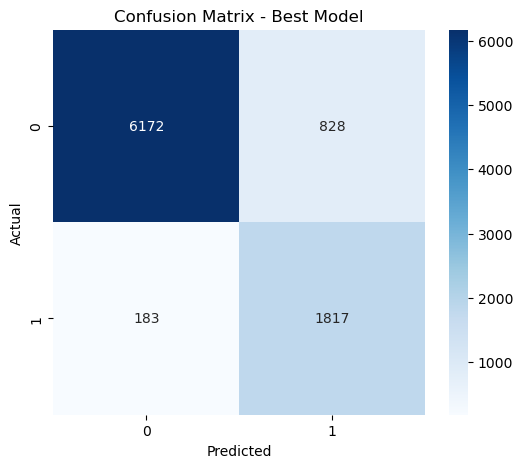

In [37]:
# Confusion Matrix for Best Tuned Model
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best Model')
plt.show()

282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step


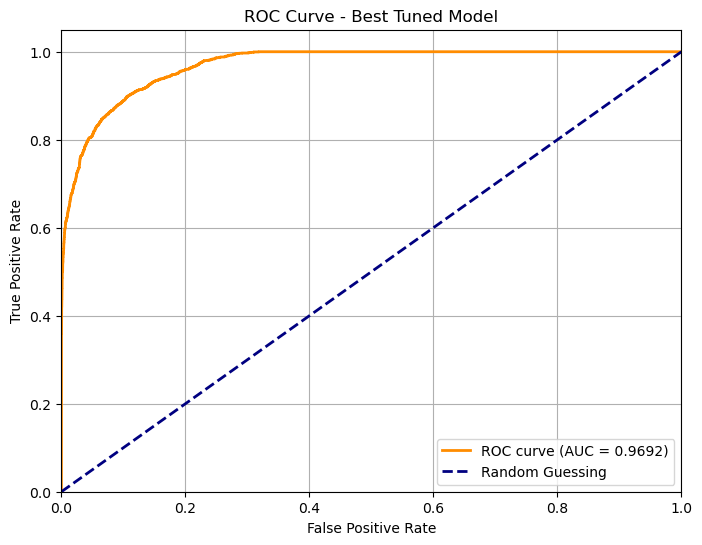

In [38]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities (not class labels) → needed for ROC
y_pred_probs = best_model.predict(X_test).ravel()  # Flatten to 1D

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best Tuned Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step


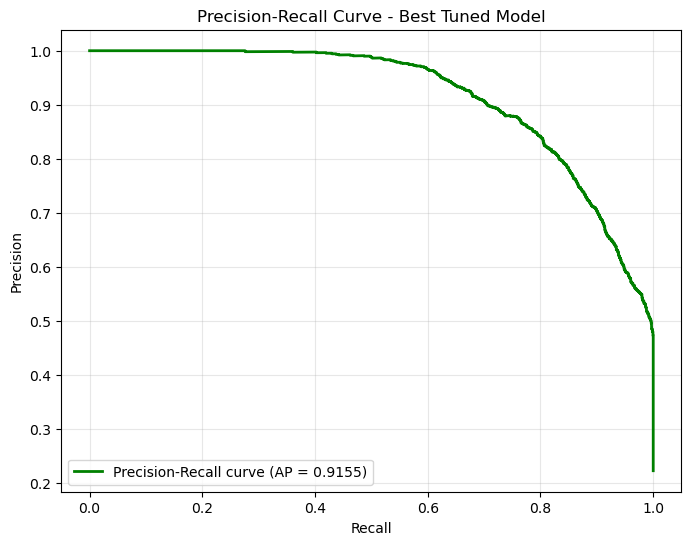

In [39]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get predicted probabilities
y_proba = best_model.predict(X_test)

# Calculate precision, recall and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calculate average precision score
avg_precision = average_precision_score(y_test, y_proba)

# Plot Precision-Recall Curve
plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='green', linewidth=2, label=f'Precision-Recall curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Best Tuned Model')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()


PermutationExplainer explainer: 9001it [11:53, 12.47it/s]                       
/var/folders/9n/6229qxsn2nb0ccgf0xrsgxb00000gp/T/ipykernel_857/1490874693.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_np, feature_names=X_test.columns)


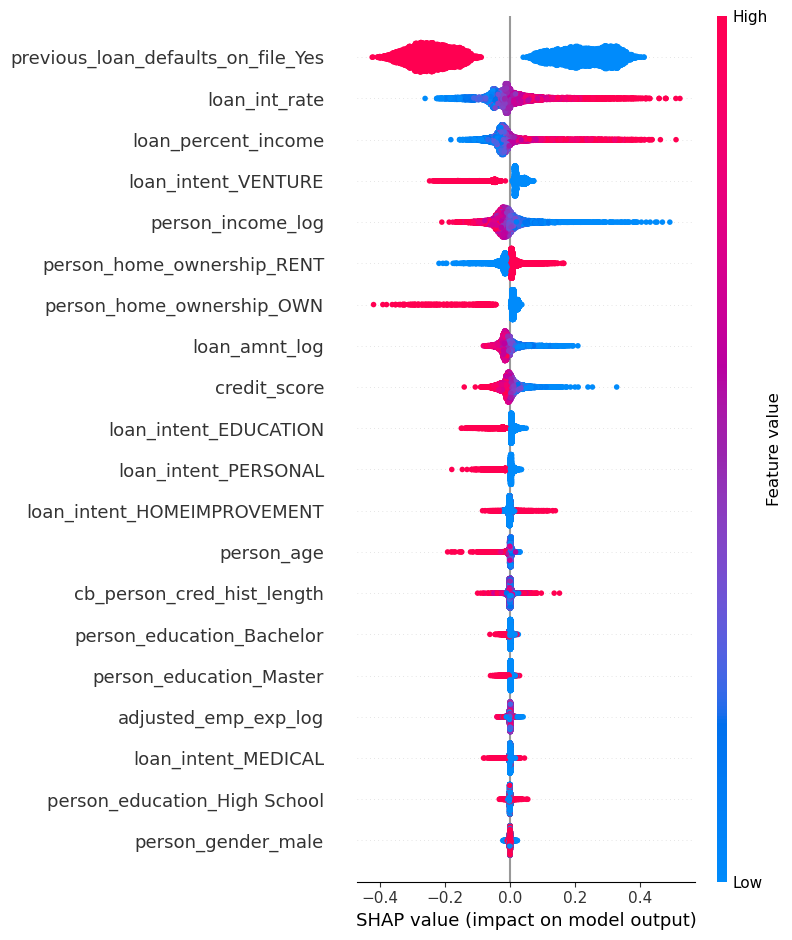

In [40]:
# SHAP Explainability - Global Feature Importance
import shap

# Converting X_test to numpy array with float32 type
X_test_np = X_test.values.astype(np.float32)

# Creating SHAP explainer
explainer = shap.Explainer(best_model, X_test_np, feature_names=X_test.columns)

# Calculating SHAP values
shap_values = explainer(X_test_np)

# Plotting SHAP summary plot
shap.summary_plot(shap_values, X_test_np, feature_names=X_test.columns)
